In [1]:
cd ..

c:\Users\auror\New_VAES\VAEs


In [2]:
import torch
import math
import numpy
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import itertools
import scipy.stats
import scipy
import random
from src.useful_functions import *

In [3]:
#Architecture parameters and distributions of stimuli
N = 10
K = 10
mix = torch.distributions.categorical.Categorical(torch.ones(2))
compo = torch.distributions.von_mises.VonMises(torch.tensor([-2.5,2.5]), torch.tensor([1,1]))
#p_x = torch.distributions.mixture_same_family.MixtureSameFamily(mix, compo)
p_x = torch.distributions.von_mises.VonMises(0,1)

#Training parameters
N_EPOCHS = 2000
N_SAMPLES = 5000
lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]

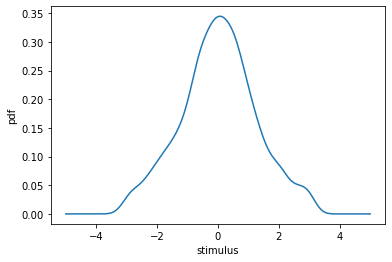

In [4]:
#probability density distribution
plot_pdf(x_samples)

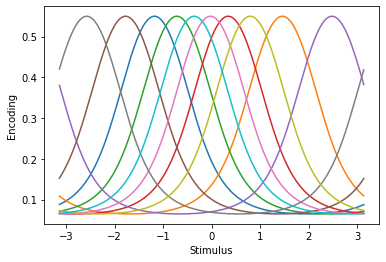

In [5]:
#CIRCULAR ENCODER
enc_circ = CircularBernoulliEncoder(N,x_sorted)
dec = MLPDecoder_circ(N,200)
r = enc_circ.sample(x_fine,100)

plot_enc(enc_circ,x_sorted)

In [6]:
#Definition of the loss terms
q = rate_ising(N)
rate = q(enc_circ,x_sorted)
dist = distortion_circular(x_sorted,enc_circ,dec)

In [7]:
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(dec.parameters())
lr = 1e-4
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
for epoch in range(N_EPOCHS):
    for x_ in x_data:
    
       dist = distortion_circular(x_,enc_circ,dec)
       loss = dist
    
       opt.zero_grad()
       loss.backward()
       opt.step()
    lossVec.append(loss.item())


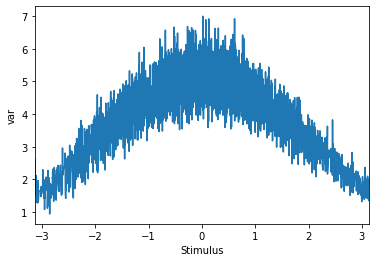

In [8]:
#decoder variance through stimulus space
plot_var_dec(enc_circ, dec, x_sorted)

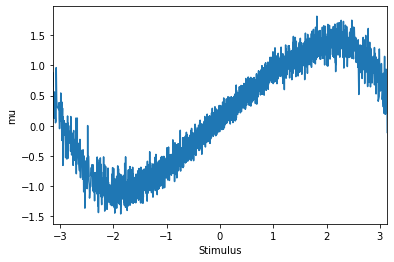

In [9]:
#decoder mu through stimulus space
plot_mu_dec(enc_circ, dec, x_sorted)

FULL TRAINING

In [10]:
#Definition of the loss elements
q = rate_ising(N)
rate = q(enc_circ,x_sorted)
dist = distortion_circular(x_sorted,enc_circ,dec)


In [11]:
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(dec.parameters(), enc_circ.parameters(), q.parameters())
lr = 1e-4
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
for epoch in range(N_EPOCHS):
    for x_ in x_data:
       rate = q(enc_circ,x_)
       dist = distortion_circular(x_,enc_circ,dec)
       loss = dist + rate 
       opt.zero_grad()
       loss.backward()
       opt.step()
    lossVec.append(loss.item())
    rateVec.append(rate.item())
    distVec.append(dist.item())

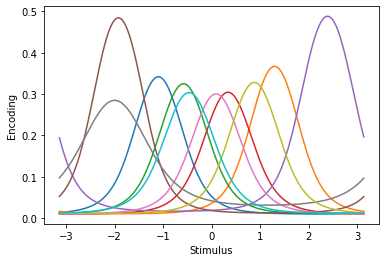

In [12]:
#ENCODING
plot_enc(enc_circ, x_sorted)

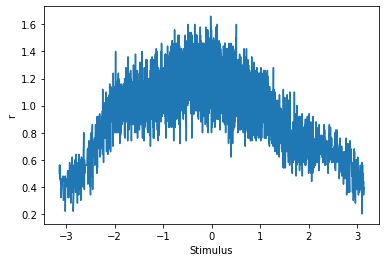

In [13]:
#neurons activity through stimulus space
plot_r(enc_circ, x_sorted)

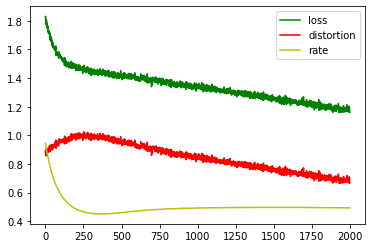

In [14]:
#LOSS
plot_loss(lossVec, distVec, rateVec)

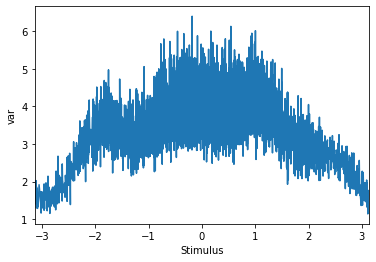

In [15]:
#DECODING

#variance of the decoder through the stimulus space
plot_var_dec(enc_circ, dec, x_sorted)


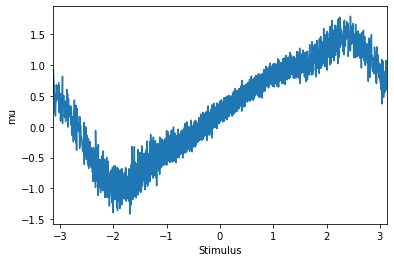

In [16]:
#decoder mu through stimulus space
plot_mu_dec(enc_circ,dec,x_sorted)

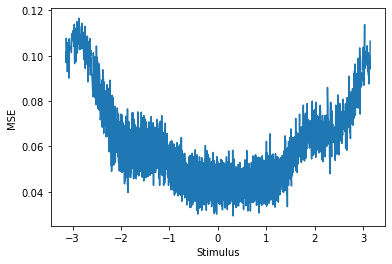

In [17]:
#Mean squared error
plot_mse(enc_circ, dec, x_sorted)

In [18]:
#GENERATIVE MODEL TEST

#generating the q(r) (using the learned J and h)

prior_params = list(q.parameters())
h_learn = prior_params[0]# 1 x 10
J_learn = prior_params[1] # 10 x 10

r_all = np.asarray(list(itertools.product([0, 1], repeat=N)))
r_all = r_all.transpose()

expo = torch.exp(torch.as_tensor(h_learn.detach().numpy()@r_all + numpy.sum(r_all*(J_learn.detach().numpy()@r_all), axis = 0)))
Z = expo.sum(dim=1)
q_r = (1/Z)*expo
q_r = torch.squeeze(q_r)

In [19]:
r_all1 = np.asarray(list(itertools.product([0, 1], repeat=N)))
r_all = torch.as_tensor(r_all1[:,None,:], dtype = torch.float32)


mu_dec_all,log_k_dec_all = dec(r_all)

In [20]:
weights = q_r
means = mu_dec_all
stdevs = torch.exp(log_k_dec_all)
mix = torch.distributions.categorical.Categorical(weights)
compo = torch.distributions.independent.Independent(torch.distributions.von_mises.VonMises(means, stdevs),0)
q_x = torch.distributions.mixture_same_family.MixtureSameFamily(mix, compo)


In [21]:
x_samples = q_x.sample((N_SAMPLES,))[:,None]
x_samples = torch.squeeze(x_samples)

Text(0, 0.5, 'pdf')

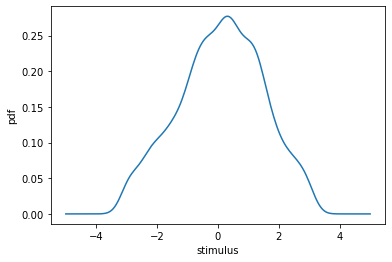

In [22]:
kde = scipy.stats.gaussian_kde(x_samples)
t_range = np.linspace(-5,5,200)
plt.plot(t_range,kde(t_range))
plt.xlabel("stimulus")
plt.ylabel("pdf")